In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!wget -O model_training_dataset.zip https://storage.googleapis.com/detect-human-ai-generated-raw-data/hugging_face_human_ai_generated_text/model_training_dataset.csv.zip


!unzip model_training_dataset.zip


--2024-11-07 09:40:58--  https://storage.googleapis.com/detect-human-ai-generated-raw-data/hugging_face_human_ai_generated_text/model_training_dataset.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1251215056 (1.2G) [application/zip]
Saving to: ‘model_training_dataset.zip’

model_training_data 100%[===================>]   1.17G  26.0MB/s    in 47s     

2024-11-07 09:41:46 (25.5 MB/s) - ‘model_training_dataset.zip’ saved [1251215056/1251215056]

Archive:  model_training_dataset.zip
  inflating: model_training_dataset.csv  
  inflating: __MACOSX/._model_training_dataset.csv  


In [47]:
import pandas as pd

# Define function to process the dataset in chunks and sample a specific fraction
def get_huggingface_sampled_texts(path="model_training_dataset.csv", max_rows=5000, chunk_size=10000):
    # Initialize lists to store sampled data
    human_text_data = []
    ai_text_data = []

    for chunk in pd.read_csv(path, chunksize=chunk_size):
        # Take a sample from each chunk to approximate the total desired sample size
        frac = max_rows / (len(chunk) * (len(human_text_data) + len(ai_text_data) + 1))

        # Sample human text
        human_chunk = chunk[['id', 'human_text', 'instructions']].sample(frac=frac).copy()
        human_chunk.rename(columns={'human_text': 'text'}, inplace=True)
        human_chunk['generated'] = 0  # Label as human-generated
        human_text_data.append(human_chunk)

        # Sample AI text
        ai_chunk = chunk[['id', 'ai_text', 'instructions']].sample(frac=frac).copy()
        ai_chunk.rename(columns={'ai_text': 'text'}, inplace=True)
        ai_chunk['generated'] = 1  # Label as AI-generated
        ai_text_data.append(ai_chunk)

    # Concatenate sampled chunks
    huggingface_sampled_combined_df = pd.concat(human_text_data + ai_text_data, ignore_index=True)

    # Shuffle the data
    huggingface_sampled_combined_df = huggingface_sampled_combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure only 10,000 rows
    huggingface_sampled_combined_df = huggingface_sampled_combined_df.iloc[:max_rows]

    return huggingface_sampled_combined_df

# Load and process the data, taking a 10,000 row sample
sample_df = get_huggingface_sampled_texts()

# Display the shape and head of the sampled combined dataframe
print("Shape of the sampled dataset:", sample_df.shape)
display(sample_df.head())




Shape of the sampled dataset: (5000, 4)


,id,text,instructions,generated
0,15c58427-78b2-466c-b5d8-33e2ed6034df,Without explore you will never know what you a...,Task: \nWrite an essay discussing why it is im...,0
1,327fbed7-91cd-4cad-a34d-10eba411f5ff,you can be happy face.\n\nYou personality is f...,Task: Write an essay that discusses whether it...,0
2,1fa3d15a-b2b1-46c5-b500-32885ff5d682,us humans should help everyone we can even if ...,Task: Write an essay discussing whether you ag...,0
3,6b0aac2d-21d7-41fe-95a1-8d02ab9e6499,This statement taught me the importance of rem...,"Task: Research the statement ""Success consists...",1
4,e4b2e3ab-0dac-43b1-98a0-331b23887bd0,Most find it very very important if you want t...,Task: Task:\n\nResearch the pros and cons of g...,0


In [48]:
df = sample_df.sample(frac=1).reset_index(drop=True)

In [70]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.7 MB/s eta 0:00:00


In [7]:
!pip install readability-lxml

In [8]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.0 MB/s eta 0:00:00


In [9]:
# Core Libraries
import numpy as np
import pandas as pd

# Text and NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import textstat
from textblob import TextBlob
from transformers import pipeline

# Advanced Libraries for Word Embeddings and Semantic Analysis
from sentence_transformers import SentenceTransformer, util

# For Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# NLTK data downloads
nltk.download('stopwords')
nltk.download('punkt')

# Load Spacy model for NLP
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Text-Based Features
Text-based features provide basic insights into the structure and composition of each text, such as word count, sentence count, and stopword usage.

Libraries in use : Natural Language Toolkit (NLTK)

- Word Count: Calculates the total number of words in each text by tokenizing the text with word_tokenize().
This gives an insight into the length and verbosity of the text.

- Sentence Count: Uses sent_tokenize() to count the number of sentences in each text. This helps understand the sentence structure and complexity.

- Average Word Length: Computes the average length of words in each text. This provides information on the complexity of vocabulary used.

- Stopwords Count: Counts the number of stopwords in each text using the NLTK English stopwords list. Stopwords are commonly used words (like “the”, “and”) that may not carry significant meaning on their own.


    

In [10]:
def text_based_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Word count,
    features['word_count'] = text_df[text_column].apply(lambda x: len(word_tokenize(x))) # using functional programming

    # Sentence count
    features['sentence_count'] = text_df[text_column].apply(lambda x: len(sent_tokenize(x)))

    # Average word length
    features['avg_word_length'] = text_df[text_column].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))

    # Stopwords count
    features['stopwords_count'] = text_df[text_column].apply(lambda x: sum([1 for word in word_tokenize(x) if word.lower() in stopwords.words('english')]))#  list comprehension

    return features

# Lexical Diversity and Readability Scores

Libraries in use : NLTK--> tokenization, Textstast--> calculate scores: built -in fucntions

Lexical diversity measures the variety of words in text, indicating richness in vocabulary, while readability scores assess how easy a text is to read. Readability metrics such as the Flesch Reading Ease and Dale-Chall Score are used.
Key Concepts

- Lexical Diversity: Measures the variety of words in a text.
    A higher lexical diversity means a richer vocabulary, while a lower one suggests repetitive or simpler language.
- Readability Scores: These scores quantify how easy or difficult it is to read a given text.
    Higher scores generally indicate simpler texts, while lower scores imply more complex language.

	• Flesch Reading Ease: A higher score --> simpler text, easy to read

	• SMOG Index: Measures the years of education needed to understand a piece of writing. B)

	• Flesch-Kincaid Grade Level: Indicates the U.S. school grade level required to understand the text.



In [11]:
def lexical_diversity_readability(text_df, text_column='text'):
    features = pd.DataFrame()

    # Lexical diversity (Unique words / Total words)
    features['lexical_diversity'] = text_df[text_column].apply(lambda x: len(set(word_tokenize(x))) / len(word_tokenize(x)) if len(word_tokenize(x)) > 0 else 0)

    # Readability Scores
    features['flesch_reading_ease'] = text_df[text_column].apply(textstat.flesch_reading_ease)
    features['smog_index'] = text_df[text_column].apply(textstat.smog_index)
    features['flesch_kincaid_grade'] = text_df[text_column].apply(textstat.flesch_kincaid_grade)

    return features

# POS Tagging Features
Part of Speech (POS) tagging helps identify grammatical structures in text, such as noun and verb counts. By examining POS distributions, we can highlight stylistic differences that may distinguish AI-generated text from human-generated text.

Libraries in use: SpaCy (nlp): Used for natural language processing, specifically to tokenize text and retrieve POS tags.



In [12]:
def pos_tagging_features(text_df, text_column='text'):
    pos_features = pd.DataFrame()

    def pos_counts(text):
        doc = nlp(text) # text parsing
        pos_counts = {token.pos_: 0 for token in doc} # dictionary with POS tags (like NOUN, VERB, ADJ)
        for token in doc:
            pos_counts[token.pos_] += 1
        return pos_counts

    pos_df = text_df[text_column].apply(pos_counts).apply(pd.Series).fillna(0) # Fill missing POS tag counts with 0 for consistency across texts

    pos_df.columns = [f'pos_{col}' for col in pos_df.columns]
    pos_features = pd.concat([pos_features, pos_df], axis=1)

    return pos_features

# Sentiment and Emotion Analysis

Sentiment and emotion analysis capture the emotional tone of the text, identifying positive, negative, or neutral sentiment and specific emotions.

Libraries in use :
1.	Hugging Face Transformers:
- Function: Provides a pre-trained pipeline for sentiment analysis.
- Usage in Code: pipeline('sentiment-analysis', truncation=True, max_length=512)
-Purpose: To analyze text and classify it as positive, negative, or neutral using a transformer model.

2.	TextBlob:
- Function: Offers tools for natural language processing, specifically sentiment analysis.
- Usage in Code: TextBlob(x).sentiment.polarity and TextBlob(x).sentiment.subjectivity

- Sentiment (Transformers): General sentiment (POSITIVE, NEGATIVE, NEUTRAL)
- Polarity (TextBlob): Degree of positivity or negativity, from -1 to 1. Hope has 1 polarity, terrible -1
- Subjectivity (TextBlob): Extent of personal opinion, from 0 to 1. " I think" --> 1

In [61]:
def sentiment_emotion_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Initialize sentiment analysis pipeline with GPU (device=0)
    sentiment_pipeline = pipeline('sentiment-analysis', device=0, truncation=True, max_length=512)

    # Apply sentiment analysis in batches
    texts = text_df[text_column].tolist()
    sentiment_results = sentiment_pipeline(texts, truncation=True, max_length=512, batch_size=32)

    # Extract sentiment labels from the results
    features['sentiment'] = [result['label'] for result in sentiment_results]

    # Polarity and subjectivity from TextBlob
    features['polarity'] = text_df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    features['subjectivity'] = text_df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    return features

# N-grams and Keyword Features
N-grams and keyword features provide insights into common phrases and important keywords, which can distinguish between human and AI-generated texts.

Libraries in Use:
- Sklearn’s CountVectorizer: Used for extracting n-grams (bigrams and trigrams) from the text and counting their occurrences.

N-gram : sequence of n adjancent words in a sentence,
- Ex: “The product is great,” the bigrams are:
"The product” - "product is" -  "product is great"
- “Humans and AI can collaborate.” the triagrams

In [14]:
def ngrams_keyword_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Bi-grams count
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bigram_matrix = vectorizer.fit_transform(text_df[text_column])
    features['bigram_count'] = bigram_matrix.sum(axis=1).A1

    # Trigrams count
    vectorizer = CountVectorizer(ngram_range=(3, 3))
    trigram_matrix = vectorizer.fit_transform(text_df[text_column])
    features['trigram_count'] = trigram_matrix.sum(axis=1).A1 # .A1 converts the sparse column vector into a 1-d np array, to work with pd df columns.

    return features

# Linguistic Complexity Features

These features analyze the complexity of sentences, including the number of clauses and the depth of syntactic structures.
- Dependency structures : its like parts of the sentence that helps to make sense, like names of people, places, or things being talked about.

- " The dog runs”...low complexity, entities : none, dependency count 0
- " Jerome is a french experienced ios developer " ...high complexity, entities: 3 , count dependency = 3

Libraries in use : 	SpaCy: NLP library, to perform dependency parsing. The **ents** attribute in SpaCy identifies entities in the text, which can act as a proxy to understand the text’s syntactic structure. Uses Named Entity Recognition (NER), to define Entities : “real-world objects” in texts...


In [69]:
# Load SpaCy's English model with only NER (for named entity recognition)
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

def linguistic_complexity_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Process text in batches to improve efficiency
    docs = nlp.pipe(text_df[text_column], batch_size=32)  # Adjust batch size as needed for performance
    features['dependency_count'] = [len(doc.ents) for doc in docs]

    return features

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# BERT Word Embedding Features

Embedding features represent text as vectors in a high-dimensional space, capturing nuanced meanings.
The embedding function converts each text sample into a 384-dimensional vector using SBERT embeddings.
- Each dimension of this vector captures some aspect of the text’s meaning, position in semantic space, or relationship with other words or phrases.
- every column in the output represents a unique embedding feature (e.g., embedding_0, embedding_1, …, embedding_383), and together they provide a rich, high-dimensional representation of the text.
- (384) is predefined by the model architecture

In [49]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import torch

# Define the function for generating BERT embeddings with optional PCA
def embedding_features_with_pca(text_df, text_column='text', n_components=50):
    # Initialize an empty DataFrame to store the features
    features = pd.DataFrame()

    # Generate embeddings using SBERT
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')  # Using GPU for speed
    embeddings = text_df[text_column].apply(lambda x: model.encode(x)).tolist()

    # Convert embeddings to a DataFrame
    embedding_df = pd.DataFrame(embeddings)
    embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]
    features = pd.concat([features, embedding_df], axis=1)

    # Apply PCA to reduce dimensions
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embedding_df)

    # Convert PCA output to DataFrame and add to features
    pca_df = pd.DataFrame(reduced_embeddings, columns=[f'pca_embedding_{i}' for i in range(n_components)])
    features = pd.concat([features, pca_df], axis=1)

    return features

# Semantic Similarity

Cosine similarity is a method to measure how alike two texts are, regardless of length. It looks at the “angle” between them in a high-dimensional space—if the angle is small, they’re similar. the “angle” between the text and its reference.

- pre-trained SBERT model converts sentences into dense vector representations (embeddings) that capture the semantic meaning.
- example : A = “AI is transforming industries.”, B is a " reference text"
- semantic_ similarity =
Cosine similarity between two vectors \( A \) and \( B \) is defined as:

$$
\text{cosine\_similarity} = \cos(\theta) = \frac{{A \cdot B}}{{\|A\| \|B\|}} = \frac{{\sum_{i=1}^{n} A_i B_i}}{{\sqrt{\sum_{i=1}^{n} A_i^2} \cdot \sqrt{\sum_{i=1}^{n} B_i^2}}}
$$



Note: I need to create a reference text, it must be a commun theme of type of language across the dataset as a benchmark. Challenge: if we make an hybrid dataset, themes are mixed which make difficult to find a reference text...
- strategy 1: maybe using a K-means on the text embeddings to group similar texts,...
- strategy 2 : pick randomly one text and run the function against...

steps:

1. Cluster the Data: Use K-means to create two clusters, one for AI-generated and one for human-generated text.

2. Select Reference Texts: Identify the reference text closest to the centroid for each cluster.

3. Calculate Similarity: For each text, calculate the similarity to the reference text of its respective cluster.




In [50]:
# Strategy 1 : k-means on embedding to find clusters

from sklearn.cluster import MiniBatchKMeans

def find_reference_texts_with_kmeans(df, text_column='text', num_clusters=2, n_components=50):
    # Get reduced embeddings
    embeddings_reduced = embedding_features_with_pca(df, text_column=text_column, n_components=n_components)

    # Run MiniBatchKMeans for faster clustering
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=100)
    cluster_labels = kmeans.fit_predict(embeddings_reduced)

    # Identify Reference Texts
    reference_texts = []
    for i in range(num_clusters):
        # Get indices for each cluster
        cluster_indices = [index for index, label in enumerate(cluster_labels) if label == i]
        cluster_embeddings = embeddings_reduced.iloc[cluster_indices]

        # Calculate centroid of the cluster
        centroid_embedding = kmeans.cluster_centers_[i]

        # Find the closest text to the centroid within the cluster
        similarities = util.cos_sim(torch.tensor(cluster_embeddings.values), torch.tensor(centroid_embedding)).numpy()
        closest_idx = similarities.argmax()
        reference_texts.append(df.iloc[cluster_indices[closest_idx]][text_column])


In [51]:
for i, text in enumerate(reference_texts):
    print(f"Cluster {i + 1} Reference Text:\n{text}\n")

Cluster 1 Reference Text:
I have a beautiful life, and my life always is with laugh, laugh, I am creazy, and I love to be creazy, my personality is unique. I don't have to feign nothing. and i like that, so I feel very happy.. I learning to be my self, so "Yes" I make a greatest accomplishment in my life, and is nice to be your self, now i feel relax, and satify with my decisions, I desmostrated what I am. If I am a creazy women who always is imperative but i feel good with that am fine. A example of this could be say "I never do something good", " I am not a good person". Ralph Waldo Emerson, cause i feel identified with what he say; I feel a winner, i feel happy with my personality, and is because i don't care what the people say, or think about me, is my life, I take my decisions. So we never will be fine.

Everybody can judge, but we have to be strong, we have to try to demostrate what we are, or what we like to do.

Razons:

We can have a lot of bad situations in this life, Maybe 

In [52]:
from sentence_transformers import util

def cosine_similarity_features(text_df, cluster_labels, reference_texts, text_column='text'):
    features = pd.DataFrame()
    similarities = []

    # Display reference texts for each cluster (AI and human)
    for i, text in enumerate(reference_texts):
        print(f"Cluster {i + 1} Reference Text (AI or Human):\n{text}\n")

    # Calculate similarity for each text to the reference text of its cluster
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
    for idx, text in enumerate(text_df[text_column]):
        cluster_label = cluster_labels[idx]  # Get the cluster label for the text
        reference_text = reference_texts[cluster_label]  # Get the reference text for that cluster

        # Encode both the text and reference text
        reference_embedding = model.encode(reference_text)
        text_embedding = model.encode(text)

        # Calculate cosine similarity between text embedding and reference embedding
        similarity = util.cos_sim(text_embedding, reference_embedding).item()
        similarities.append(similarity)

    features['semantic_similarity'] = similarities
    return features

# Structural and Formatting Features
Capture line breaks, indentation, or special formatting often present in human-written text.

Human texts often have structured paragraphing and a varied use of punctuation for emphasis and clarity...

In [53]:
def structural_formatting_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Line break count
    features['line_break_count'] = text_df[text_column].apply(lambda x: x.count('\n'))

    # Punctuation count
    features['punctuation_count'] = text_df[text_column].apply(lambda x: sum([1 for char in x if char in '.,;!?']))

    return features

In [54]:
def instruction_based_features(text_df, text_column='instructions'):
    features = pd.DataFrame()

    # Instruction word count
    features['instruction_word_count'] = text_df[text_column].apply(lambda x: len(word_tokenize(x)) if pd.notna(x) else 0)

    return features

# Topic Modeling Features

The topic_modeling_features function target to identify latent themes in the text by using topic modeling. This method provides insights into the primary subjects discussed in the text and assigns each text sample a probability distribution across a set number of topics.

Libraries in use:
- Scikit-Learn: For CountVectorizer to create a document-term matrix.
- Scikit-Learn LatentDirichletAllocation (LDA): For topic modeling, to capture underlying topics in the text.


CountVectorizer:
- Transforms text into a document-term matrix.
- max_df=0.95: Ignores terms that appear in more than 95% of the documents (common words that may not contribute to topic distinction).
- min_df=2: Ignores terms that appear in fewer than 2 documents (rare words).

Latent Dirichlet Allocation (LDA):
- Creates an instance of the LDA model with n_topics as the number of topics.
- n_topics=5 means the function will attempt to identify 5 distinct topics
- Fits the LDA model on the document-term matrix, learning the probability distribution of terms across topics.


Note: Maybe when using a bigger dataset, i should find topics for each ...not clear yet...


In [75]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


def topic_modeling_features(text_df, text_column='text', n_topics=6, max_features=5000):
    features = pd.DataFrame()

    # Vectorize the text data with fewer terms
    vectorizer = CountVectorizer(max_df=0.8, min_df=5, stop_words='english', max_features=max_features)
    doc_term_matrix = vectorizer.fit_transform(text_df[text_column])

    # Fit the LDA model with a smaller document-term matrix
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)

    # Transform the document-term matrix to topic distribution
    topic_values = lda.transform(doc_term_matrix)
    topic_df = pd.DataFrame(topic_values, columns=[f'topic_{i}' for i in range(n_topics)])

    features = pd.concat([features, topic_df], axis=1)

    return features

# Repetition Detection Function
This function will calculate the frequency of repeated phrases or words. We’ll use Counter from the collections module to count repeated words or phrases in the text.

In [55]:
from collections import Counter
import pandas as pd

def repetition_features(text_df, text_column='text', n=2):
    features = pd.DataFrame()

    def detect_repetition(text):
        words = text.split()
        phrases = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
        phrase_counts = Counter(phrases)
        repeated_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}
        return len(repeated_phrases)  # count of unique repeated phrases

    features['repetition_count'] = text_df[text_column].apply(detect_repetition)

    return features

# Error-Checking Function Using TextBlob

In [71]:
from spellchecker import SpellChecker


def spelling_error_features(text_df, text_column='text'):
    features = pd.DataFrame()
    spell = SpellChecker()

    def count_spelling_errors(text):
        # Tokenize the text by splitting it into words
        words = text.split()
        # Identify misspelled words
        misspelled_words = spell.unknown(words)
        # The count of spelling errors is the number of unique misspelled words
        return len(misspelled_words)

    features['spelling_errors'] = text_df[text_column].apply(count_spelling_errors)

    return features

In [57]:
# Calling internal features
text_features = text_based_features(df, text_column='text')

In [58]:
lexical_features = lexical_diversity_readability(df, text_column='text')

In [59]:
pos_features = pos_tagging_features(df, text_column='text')

In [62]:
sentiment_features = sentiment_emotion_features(df, text_column='text')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [63]:
ngram_features = ngrams_keyword_features(df, text_column='text')

In [72]:
complexity_features = linguistic_complexity_features(df, text_column='text')

In [65]:
structural_features = structural_formatting_features(df, text_column='text')

In [66]:
instruction_features = instruction_based_features(df, text_column='instructions')

In [67]:
repetition_features = repetition_features(df, text_column='text')

In [73]:
spelling_error_features = spelling_error_features(df, text_column='text')

In [74]:

# Concatenate internal features
internal_features = pd.concat([
    text_features,
    lexical_features,
    pos_features,
    sentiment_features,
    ngram_features,
    complexity_features,
    structural_features,
    repetition_features,
    spelling_error_features
], axis=1)

In [76]:
# Calling external features
embedding_features_df = embedding_features_with_pca(df, text_column='text')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
topic_features = topic_modeling_features(df, text_column='text', n_topics=6)

In [78]:
semantic_features = cosine_similarity_features(df, cluster_labels, reference_texts, text_column='text')

Cluster 1 Reference Text (AI or Human):
I have a beautiful life, and my life always is with laugh, laugh, I am creazy, and I love to be creazy, my personality is unique. I don't have to feign nothing. and i like that, so I feel very happy.. I learning to be my self, so "Yes" I make a greatest accomplishment in my life, and is nice to be your self, now i feel relax, and satify with my decisions, I desmostrated what I am. If I am a creazy women who always is imperative but i feel good with that am fine. A example of this could be say "I never do something good", " I am not a good person". Ralph Waldo Emerson, cause i feel identified with what he say; I feel a winner, i feel happy with my personality, and is because i don't care what the people say, or think about me, is my life, I take my decisions. So we never will be fine.

Everybody can judge, but we have to be strong, we have to try to demostrate what we are, or what we like to do.

Razons:

We can have a lot of bad situations in thi

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [79]:
# Concatenate external features
external_features = pd.concat([
    embedding_features_df,
    topic_features,
    semantic_features
], axis=1)

In [91]:
# Generate Internal and External Datasets
internal_df = pd.concat([df, internal_features], axis=1)
external_df = pd.concat([df, external_features], axis=1)

# Display the internal and external DataFrames for verification
print("Internal Features Dataset:")
display(internal_df.head())
print(internal_df.shape)
print(internal_df.columns)



Internal Features Dataset:


,id,text,instructions,generated,word_count,sentence_count,avg_word_length,stopwords_count,lexical_diversity,flesch_reading_ease,...,sentiment,polarity,subjectivity,bigram_count,trigram_count,dependency_count,line_break_count,punctuation_count,repetition_count,spelling_errors
0,430cb79f-a695-4af5-962f-8c6315688541,And this could help the younger students learn...,Task: Develop a volunteer program at your scho...,0,243,10,4.296296,124,0.374486,81.67,...,NEGATIVE,0.093966,0.321456,229,228,0,0,9,30,12
1,505d44a5-2a83-4f8d-8d81-6e6c2c4080f0,Also students would be able to know how to wor...,Task: Explore the advantages and disadvantages...,0,744,20,3.840054,387,0.250000,59.50,...,POSITIVE,0.219448,0.481227,650,649,19,8,40,92,37
2,21cc033f-c75f-4174-8c80-12335caa73d2,I know she would be so happy if I become an ac...,Task: Write an essay describing why you would ...,0,393,14,3.933842,183,0.442748,61.60,...,POSITIVE,0.280357,0.545198,319,318,4,8,45,30,45
3,cff93e5e-6c62-473d-b7db-15cfa1b03013,She has since accomplished her dream and becom...,Task: Task:\nDevelop an essay discussing the i...,1,315,13,4.063492,162,0.536508,67.59,...,POSITIVE,0.330245,0.623077,267,266,2,7,27,14,28
4,bf1fd141-9870-4061-9c6d-302d728ed066,The thoughts of how the violin was not going t...,Task: \n\n1. Research the history and backgrou...,0,921,53,3.753529,449,0.345277,80.82,...,NEGATIVE,0.193705,0.440205,752,751,29,8,90,69,78


(5000, 40)
Index(['id', 'text', 'instructions', 'generated', 'word_count',
       'sentence_count', 'avg_word_length', 'stopwords_count',
       'lexical_diversity', 'flesch_reading_ease', 'smog_index',
       'flesch_kincaid_grade', 'pos_CCONJ', 'pos_PRON', 'pos_AUX', 'pos_VERB',
       'pos_DET', 'pos_ADJ', 'pos_NOUN', 'pos_ADP', 'pos_PUNCT', 'pos_PART',
       'pos_SCONJ', 'pos_ADV', 'pos_NUM', 'pos_SPACE', 'pos_PROPN', 'pos_INTJ',
       'pos_X', 'pos_SYM', 'sentiment', 'polarity', 'subjectivity',
       'bigram_count', 'trigram_count', 'dependency_count', 'line_break_count',
       'punctuation_count', 'repetition_count', 'spelling_errors'],
      dtype='object')


In [104]:
# Unique values for each column individually
print("Sentiment Labels:", internal_df['sentiment'].unique())


Sentiment Labels: ['NEGATIVE' 'POSITIVE']
Polarity Values: [0.09396645 0.2194479  0.28035714 ... 0.14861111 0.07317708 0.26460317]
Subjectivity Values: [0.32145563 0.48122665 0.54519841 ... 0.57057823 0.65888889 0.40234375]


In [92]:
print("External Features Dataset:")
display(external_df.head())
external_df.shape
print(external_df.columns)

External Features Dataset:


,id,text,instructions,generated,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,pca_embedding_47,pca_embedding_48,pca_embedding_49,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,semantic_similarity
0,430cb79f-a695-4af5-962f-8c6315688541,And this could help the younger students learn...,Task: Develop a volunteer program at your scho...,0,-0.021596,0.078525,0.040416,-0.029278,-0.013082,0.009041,...,-0.077267,-0.025724,-0.002629,0.001789,0.001778,0.789515,0.001782,0.001776,0.203360,0.600275
1,505d44a5-2a83-4f8d-8d81-6e6c2c4080f0,Also students would be able to know how to wor...,Task: Explore the advantages and disadvantages...,0,-0.068622,0.029963,0.006228,0.025194,0.029046,-0.062798,...,-0.022827,0.054249,0.038267,0.000647,0.228088,0.068696,0.014417,0.000643,0.687508,0.459209
2,21cc033f-c75f-4174-8c80-12335caa73d2,I know she would be so happy if I become an ac...,Task: Write an essay describing why you would ...,0,-0.000714,-0.050385,0.054714,-0.034778,-0.043746,0.100212,...,0.031744,-0.051874,0.063445,0.045482,0.001307,0.058216,0.131785,0.064715,0.698495,0.272538
3,cff93e5e-6c62-473d-b7db-15cfa1b03013,She has since accomplished her dream and becom...,Task: Task:\nDevelop an essay discussing the i...,1,0.037692,0.118558,0.037200,0.036465,-0.001685,-0.025846,...,0.031718,0.006883,0.038989,0.001554,0.351923,0.001557,0.001563,0.404069,0.239334,0.379621
4,bf1fd141-9870-4061-9c6d-302d728ed066,The thoughts of how the violin was not going t...,Task: \n\n1. Research the history and backgrou...,0,-0.016767,-0.033046,0.087964,-0.025000,-0.080547,-0.016805,...,0.043579,0.074312,0.074056,0.263019,0.000591,0.000588,0.000589,0.000592,0.734621,0.172330


Index(['id', 'text', 'instructions', 'generated', 'embedding_0', 'embedding_1',
       'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5',
       ...
       'pca_embedding_47', 'pca_embedding_48', 'pca_embedding_49', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'semantic_similarity'],
      dtype='object', length=445)


# Aggregated Internal Features

In [96]:
def aggregate_internal_features(internal_df):
    aggregated_features = pd.DataFrame()

    # 1. Ratios for Counts
    # Ratios that make sense relative to word_count or sentence_count
    aggregated_features['word_count_ratio'] = internal_df['word_count'] / internal_df['sentence_count']
    aggregated_features['sentence_count_ratio'] = internal_df['sentence_count'] / internal_df['word_count']

    aggregated_features['stopwords_ratio'] = internal_df['stopwords_count'] / internal_df['word_count']
    aggregated_features['punctuation_ratio'] = internal_df['punctuation_count'] / internal_df['word_count']
    aggregated_features['sentence_word_ratio'] = internal_df['sentence_count'] / internal_df['word_count']
    aggregated_features['line_break_ratio'] = internal_df['line_break_count'] / internal_df['sentence_count']
    aggregated_features['repetition_ratio'] = internal_df['repetition_count'] / internal_df['word_count']
    aggregated_features['bigram_count_ratio'] = internal_df['bigram_count'] / internal_df['word_count']
    aggregated_features['trigram_count_ratio'] = internal_df['trigram_count'] / internal_df['word_count']
    aggregated_features['dependency_ratio'] = internal_df['dependency_count'] / internal_df['sentence_count']
    aggregated_features['spelling_errors_ratio'] = internal_df['spelling_errors'] / internal_df['word_count']

    # 2. POS Tag Ratios
    pos_columns = [col for col in internal_df.columns if 'pos_' in col]
    for pos_col in pos_columns:
        aggregated_features[f'{pos_col}_ratio'] = internal_df[pos_col] / internal_df['word_count']

    # 3. Direct Inclusion of Features (as-is)
    # Keep features that don't require ratios or are already averages or normalized
    retained_features = internal_df[[
        'avg_word_length',
        'lexical_diversity',
        'flesch_reading_ease',
        'smog_index',
        'flesch_kincaid_grade',
        'polarity',
        'subjectivity',
        'sentiment'
    ]].copy()

    # Combine aggregated ratios and retained features
    final_internal_features = pd.concat([aggregated_features, retained_features], axis=1)

    return final_internal_features

In [97]:
# Generate the aggregated internal features
internal_aggregated = aggregate_internal_features(internal_df)

# Optionally, add the target column for correlation analysis
internal_aggregated['generated'] = internal_df['generated']
internal_aggregated.shape

(5000, 38)

Sentiment Labels: ['NEGATIVE' 'POSITIVE']
Polarity Values: [0.09396645 0.2194479  0.28035714 ... 0.14861111 0.07317708 0.26460317]
Subjectivity Values: [0.32145563 0.48122665 0.54519841 ... 0.57057823 0.65888889 0.40234375]


In [98]:
internal_aggregated.head()

,word_count_ratio,sentence_count_ratio,stopwords_ratio,punctuation_ratio,sentence_word_ratio,line_break_ratio,repetition_ratio,bigram_count_ratio,trigram_count_ratio,dependency_ratio,...,pos_SYM_ratio,avg_word_length,lexical_diversity,flesch_reading_ease,smog_index,flesch_kincaid_grade,polarity,subjectivity,sentiment,generated
0,24.300000,0.041152,0.510288,0.037037,0.041152,0.000000,0.123457,0.942387,0.938272,0.000000,...,0.0,4.296296,0.374486,81.67,6.7,7.7,0.093966,0.321456,NEGATIVE,0
1,37.200000,0.026882,0.520161,0.053763,0.026882,0.400000,0.123656,0.873656,0.872312,0.950000,...,0.0,3.840054,0.250000,59.50,10.1,14.1,0.219448,0.481227,POSITIVE,0
2,28.071429,0.035623,0.465649,0.114504,0.035623,0.571429,0.076336,0.811705,0.809160,0.285714,...,0.0,3.933842,0.442748,61.60,12.8,11.2,0.280357,0.545198,POSITIVE,0
3,24.230769,0.041270,0.514286,0.085714,0.041270,0.538462,0.044444,0.847619,0.844444,0.153846,...,0.0,4.063492,0.536508,67.59,12.0,8.9,0.330245,0.623077,POSITIVE,1
4,17.377358,0.057546,0.487514,0.097720,0.057546,0.150943,0.074919,0.816504,0.815418,0.547170,...,0.0,3.753529,0.345277,80.82,9.9,5.9,0.193705,0.440205,NEGATIVE,0


  sentiment  sentiment_numeric
0  NEGATIVE                  0
1  POSITIVE                  1
2  POSITIVE                  1
3  POSITIVE                  1
4  NEGATIVE                  0


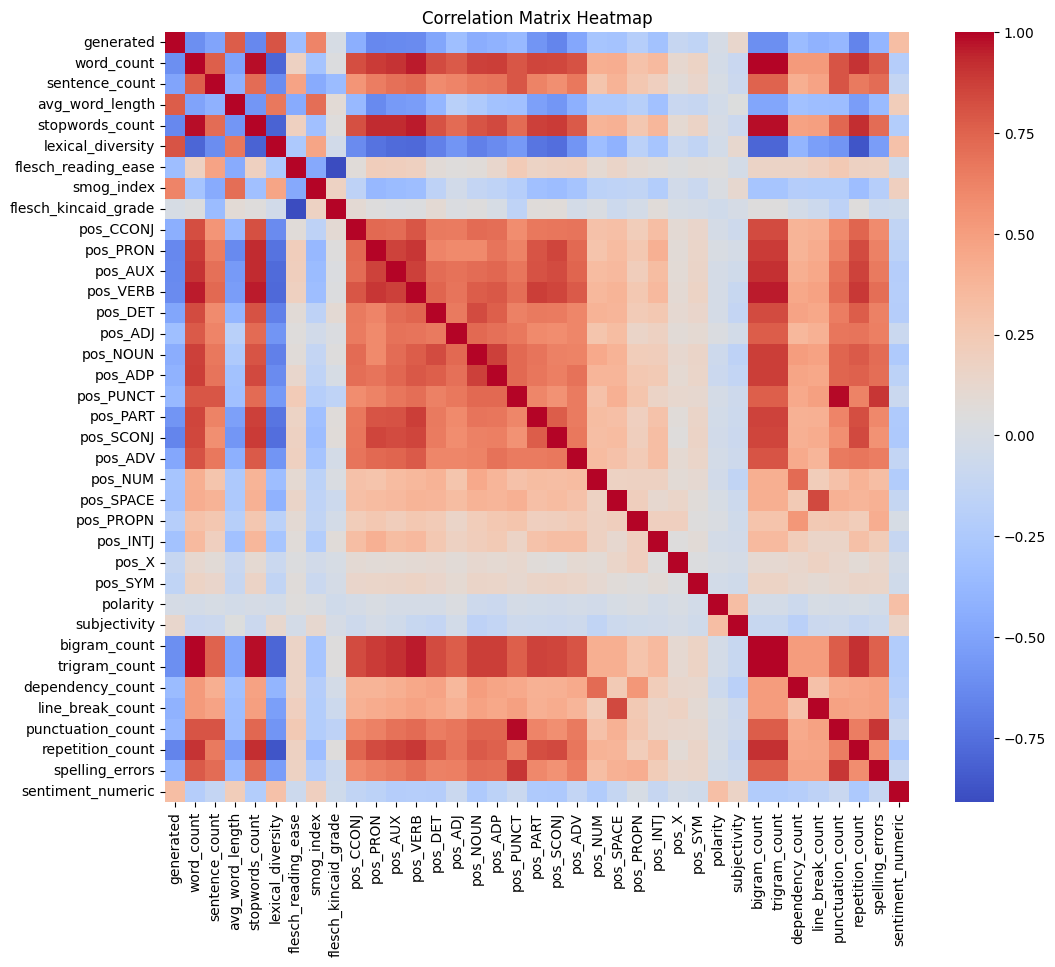


Correlation with 'generated' column:
 generated               1.000000
lexical_diversity       0.803550
avg_word_length         0.773443
smog_index              0.613354
sentiment_numeric       0.327849
subjectivity            0.133721
flesch_kincaid_grade    0.000211
polarity               -0.007844
pos_X                  -0.106456
pos_SYM                -0.141311
pos_PROPN              -0.206734
pos_NUM                -0.283176
pos_SPACE              -0.301724
pos_INTJ               -0.310462
pos_ADJ                -0.329703
flesch_reading_ease    -0.338315
dependency_count       -0.353211
pos_PUNCT              -0.366771
punctuation_count      -0.386663
spelling_errors        -0.391958
pos_ADP                -0.409892
line_break_count       -0.415165
pos_CCONJ              -0.432727
pos_NOUN               -0.440800
pos_ADV                -0.479158
pos_DET                -0.488937
sentence_count         -0.491196
pos_PART               -0.575833
word_count             -0.603313
bigr

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'sentiment' to numeric format
internal_df['sentiment_numeric'] = internal_df['sentiment'].map({'NEGATIVE': 0, 'POSITIVE': 1})

# Verify that the column is added
print(internal_df[['sentiment', 'sentiment_numeric']].head())

# Calculate the correlation matrix with only numeric columns
numeric_df = internal_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

# Display the correlation of all features with 'generated'
correlation_with_generated = correlation_matrix['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_with_generated)

# Aggregated External Features

In [111]:
print(external_df.dtypes)

id                      object
text                    object
instructions            object
generated                int64
embedding_0            float32
                        ...   
topic_2                float64
topic_3                float64
topic_4                float64
topic_5                float64
semantic_similarity    float64
Length: 445, dtype: object


# For Yuka inspiration <3




Idea to analyze slang as a feature:

1.	Generate Word Clouds: Create word clouds separately for AI and human text to observe distinct patterns.
2.	Focus on Colloquial Terms: Pay special attention to informal language, abbreviations, or region-specific phrases, as these are often more prominent in human language.
3.	Apply Slang Detection: Consider implementing a dictionary of slang terms and measuring the frequency of these terms across AI and human text samples.


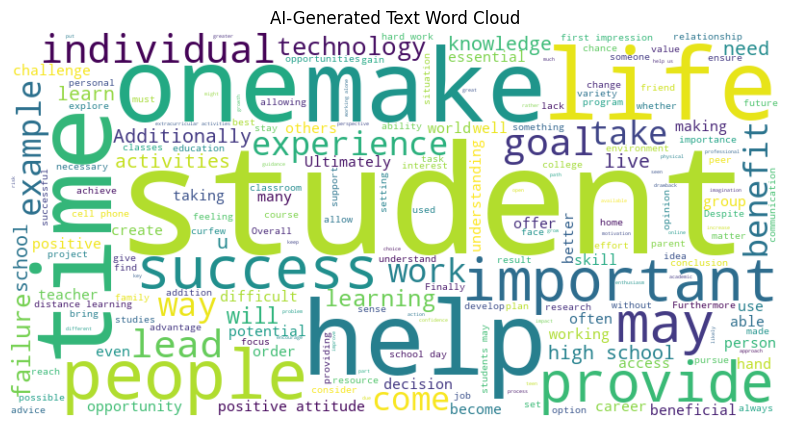

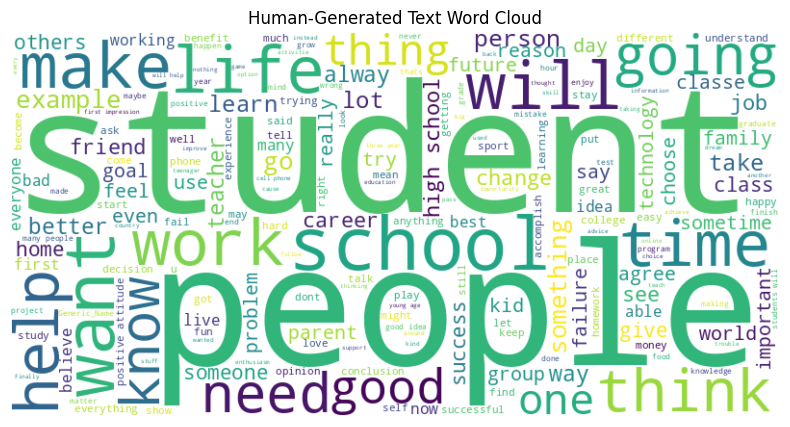

In [113]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming `df` is your DataFrame and 'text' column contains the text data
# And 'generated' column has 1 for AI-generated and 0 for human-generated

def generate_wordcloud(df, generated_value, title):
    # Filter the DataFrame based on AI or human-generated text
    text_data = " ".join(df[df['generated'] == generated_value]['text'])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create word cloud for AI-generated text
generate_wordcloud(df, generated_value=1, title='AI-Generated Text Word Cloud')



# Create word cloud for human-generated text
generate_wordcloud(df, generated_value=0, title='Human-Generated Text Word Cloud')